# Box Model - flopy

## Model Description 
This intially constructs the 2D (heterogeneous) steady state box model that you built for your BoxModel_Manual assignment

#### Dimensions: 
- 25 by 25 by 1
- dx = dy = 100 m
- dz = 10 m  

#### Subsurface Properties: 
- Heterogeneous 
- K = 1.0 m/day in x, y and z with a 5x5 inclusion with K = 0.1 m/day centered in the domain.  Inclusion is 5x5 cells.
- Porosity = 0.35
- Specific yield = 0.3
- Storage coefficient=0.001  

#### Boundary Conditions: 
 - Right boundary is constant head of 10 m relative to the datum, which is located at the bottom of the domain.  
 - Left boundary is a constant head of 20 m relative to the datum, which is located at the bottom of the domain.


## 1. Setup the environment

In [51]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 

#Supress depricaiton warmnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# If you want to calculate the harmonic mean in python you need to conda install scipy 
# and uncomment this line
from scipy.stats import hmean

## 2. Create the model object

In [52]:
modelname = "FarmModel_flopy"
exe_path = '/workspaces/modflow/mf2005'
m = flopy.modflow.Modflow(modelname, exe_name = exe_path)

In [53]:
#optional delete old run files
run = 'n'
if run == 'y':
    # file_extensions = ['.dis','.bas','.lpf','.oc','.pcg','.wel']
    file_extensions = ['.dis','.bas','.bcf','.oc','.pcg']
    for ext in file_extensions:
        os.remove(modelname + ext)

## 3. Setup the discretization (DIS package)

For more details on DIS package inputs refer to : https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfdis.html 

#### 3.1 Spatial discretization

In [ ]:
nrow = 30 #number of rows
ncol = 30 #number of columns
nlay = 1  #number of layers

dx= 100 #width of grid cells in x direction 
dy= 100 #width of grid cells in y direction 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y
ztop = 200.    #top elevation 
zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction

#### 3.2 Temporal discretization 

In [55]:
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

#### 3.3 Create DIS object

In [56]:
#create flopy discretization object, length and time are meters (2) and days (4)
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

#### 3.4 Plot the grid

For help on this function see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.plot.plotutil.html

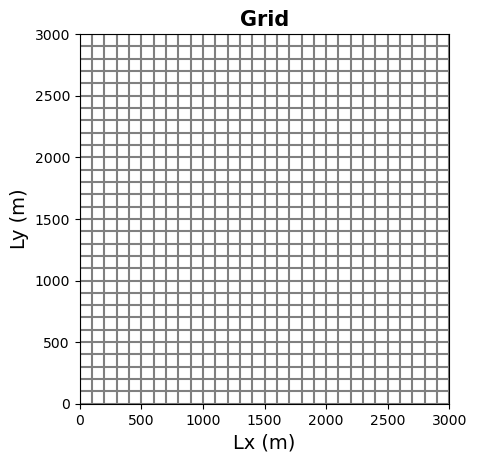

In [57]:
#use flopy to plot the grid of model 'm'
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid() 
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Grid', fontsize = 15, fontweight = 'bold')
plt.show()

## 4. Setup constant head boundaries, active cells and initial heads (BAS Package)

For more details on the BAS package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfbas.html

#### 4.1 Define cell activity: IBOUND 

In [58]:
#create ibound as array of ints = 1
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active     

#set constant head boundary on the left
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 
ibound[:,:,-1] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 

#print("ibound values: \n", ibound)

#### 4.2 Define starting heads 

In [59]:
#setup initial heads as 1 everywhere and 7 on the left boundary 
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, 0] = 20    #replace first (left) col with desired head value
H_init[:, :, -1] = 10    #replace first (left) col with desired head value

#print("starting head values: \n", H_init)

#### 4.3 Create BAS object

In [60]:
#create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#### 4.4 Plot the grid and ibound

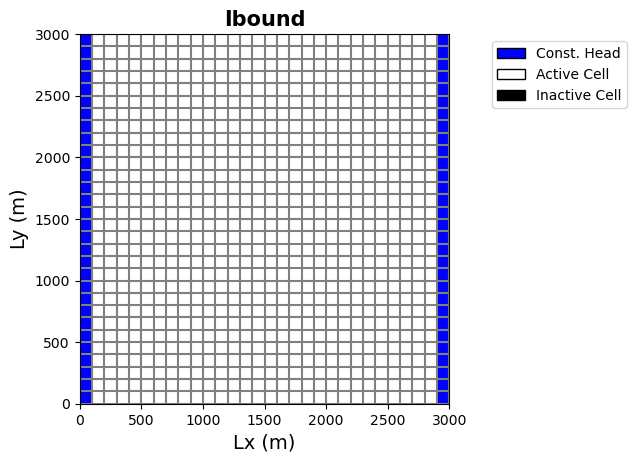

In [61]:
#plot grid and ibound
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)

## 5. Setup Layer Properties  (LPF Package)

For more details on LPF package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mflpf.html

#### 5.1 Set layer properties

In [62]:
K_horiz = 1.    #horizontal hydraulic conductivity 
K_vert = 1    #assign vertical hydraulic conductivity (along z axis)
n = 0.35        #assign porosity
Ss = 0.001      #assign storage coefficient
Sy = 0.3        #assign specific yield
uncnf = 0       #0=confined, >0 = unconfined

#### 5.2 Make LPF object

In [63]:
#assigns horizontal and vertical Ks and saves cell-by-cell budget data
# lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=K_horiz, 
#                                vka=K_vert, ss=Ss,
#                                sy=Sy,storagecoefficient=True, ipakcb=53) 


## 5b. Setup Cell-byCell Properties  (BCF Package)

For more details on LPF package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfbcf.html

#### 5b.1 Set cell properties and show K in top layer

In [64]:
K_vals = np.zeros((nlay,nrow,ncol))
K_vals[:,:,:] = 1        
K_vals

array([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.

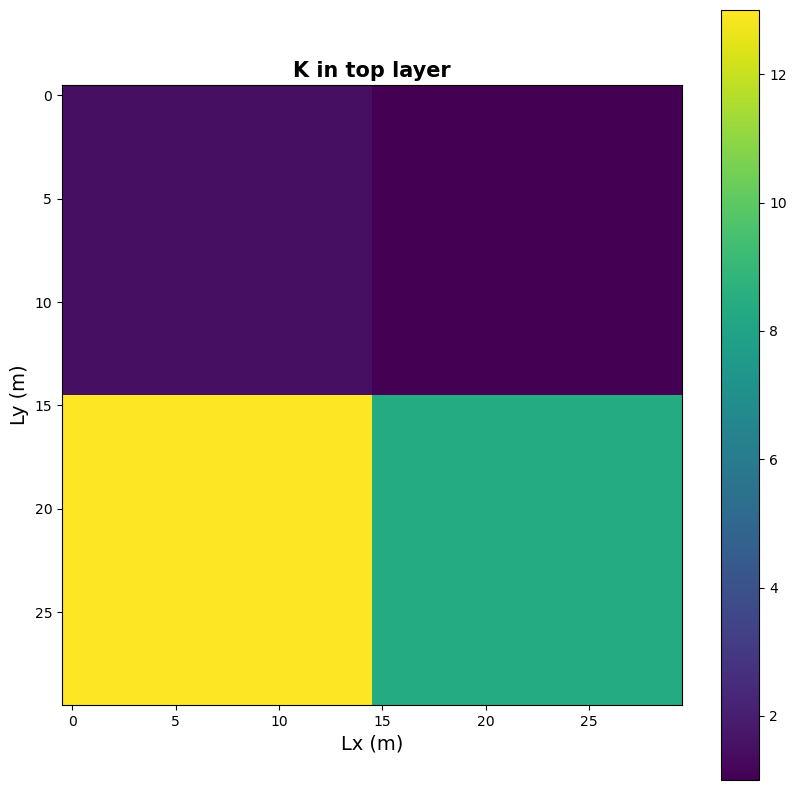

In [65]:
K_vals = np.zeros((nlay,nrow,ncol))
K_vals[:,:,:] = 1             # homoogeneous background hydraulic conductivity 
K_incl1 = 1.5 # K inclusion value
K_incl2 = 13
K_incl3 = 1
K_incl4 = 8.4

K_vals[:, 15:30, 0:15] = K_incl1 
K_vals[:, 0:15, 0:15] = K_incl2 
K_vals[:, 15:30, 15:30] = K_incl3 
K_vals[:, 0:15, 15:30] = K_incl4 

n = 0.35        #assign porosity
Ss = 0.001      #assign storage coefficient
Sy = 0.3        #assign specific yield
uncnf = 0       #0=confined, >0 = unconfined

#plot K values in top layer
fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('K in top layer', fontsize = 15, fontweight = 'bold')
plt.imshow(np.flipud(K_vals[0,:,:]), interpolation='none')
plt.colorbar()
plt.show()

#### 5b.2 Make BCF object

In [66]:
K_vals[0,:,:].shape

(30, 30)

In [67]:
#assigns horizontal and vertical Ks and saves cell-by-cell budget data
bcf = flopy.modflow.ModflowBcf(m, ipakcb=53, intercellt=0, laycon=3, trpy=1.0, hdry=-1e+30, iwdflg=0, wetfct=0.1, iwetit=1, ihdwet=0, tran=1.0, hy=K_vals[0,:,:], vcont=1.0, sf1=Ss, sf2=Sy, wetdry=-0.01, extension='bcf', unitnumber=None, filenames=None) 


## 6. Setup outputs by stress period (OC Package)
For more details on OC Package: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfoc.html

#### 6.1 Setup outputs

In [68]:
#create oc stress period data. 
#(0,0) tells OC package to save data for stress period 1, time step 1.
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 

print("oc stress period data: \n", spd)

oc stress period data: 
 {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}


#### 6.2 Make OC object 

In [69]:
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

## 7. Set the numerical solver (PCG Package)

We are using the Preconditioned Conjugate Gradient package:

Additionally, MODFLOW online describes these solvers: https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?oc.htm

And Flopy documents its communication with the PCG MODFLOW package: http://modflowpy.github.io/flopydoc/mfpcg.html

#### 7.1 Make the PCG object

In [70]:
pcg = flopy.modflow.ModflowPcg(model=m)

## 8. Add wells for the constant flux boundary (WEL Package)
For more details on the WEL package see: https://flopy.readthedocs.io/en/3.3.4/source/flopy.modflow.mfwel.html

#### 8.1 Setup the well parameters (use this to set a defined flux boundary)

In [71]:
Q_in = -10                        # Volumetric flux from the well in units of L3/T 
fluxes = [0,1,1,Q_in]

sp_fluxes = {0: [fluxes]}              #create a dictionary with entries for each stress period

print(sp_fluxes)

{0: [[0, 1, 1, -10]]}


#### 8.2 Make the WEL object

In [72]:
wel = flopy.modflow.mfwel.ModflowWel(m, stress_period_data=sp_fluxes)  #create object for WEL package

## 9. Add recharge (RCH Package)

For more details on the recharge package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfrch.html

#### 9.1 Setup recharge value

In [73]:
#Recharge 
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
recharge = 0.0001               #m/day      
rech_zone[6:10,6:10] = recharge
#rech_zone[:, :]= recharge 


rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     #create rch object


## 9. Write inputs and run the model 

#### 9.1 Write Inputs

In [74]:
m.write_input()    #uses the package objects created above to actually write the text files, 
                    #and saves to folder that this script is in
                    #after this step you should see the files appear in your folder


#### 9.2 Run the model

In [75]:
success, mfoutput = m.run_model(pause=False, report=True, silent=False)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: ../../modflow/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: FarmModel_flopy.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2026/02/10  5:14:58

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2026/02/10  5:14:58
 Elapsed run time:  0.030 Seconds

  Normal termination of simulation


## 10. Plot the results  

#### 10.1 Read in the model outputs

For information on binary files see: http://modflowpy.github.io/flopydoc/binaryfile.html 

For information on flow budget files see: 
http://modflowpy.github.io/flopydoc/binaryfile.html#flopy.utils.binaryfile.CellBudgetFile

##### Read the heads 

In [76]:
headobj = bf.HeadFile(modelname+'.hds')    #reads the binary head file
times = headobj.get_times()                #returns a list of timesteps
head = headobj.get_data(totim=times[-1])        #returns a numpy array of heads for specified time (last timestep)

#print('timesteps:', times)         
#print('final head:', 'dimensions', np.shape(head), '\n', head)    
#print('initial head:', 'dimensions', np.shape(H_init), '\n', H_init)
#print('well fluxes:', 'dimensions', np.shape(fluxes), '\n', fluxes)

##### Write Heads as csv

In [77]:
with open('FP_heads.csv', 'w', newline='') as csvfile:  #creates an empty csv file called FP_heads
    writer = csv.writer(csvfile, delimiter=',')        
    for i in range(len(head[0,:,0])):                    #writes each row
        writer.writerow(head[0,i,:])


##### Read the Water Balance and use it to find distribution of fluxes along boundary

In [78]:
frf[0][0,:,:].shape

(30, 30)

(0.0, 29.0)

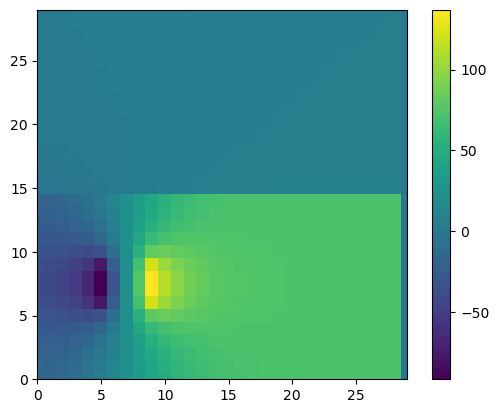

In [79]:
plt.imshow(frf[0][0,:,:])
plt.colorbar()
plt.ylim(0,29)
plt.xlim(0,29)

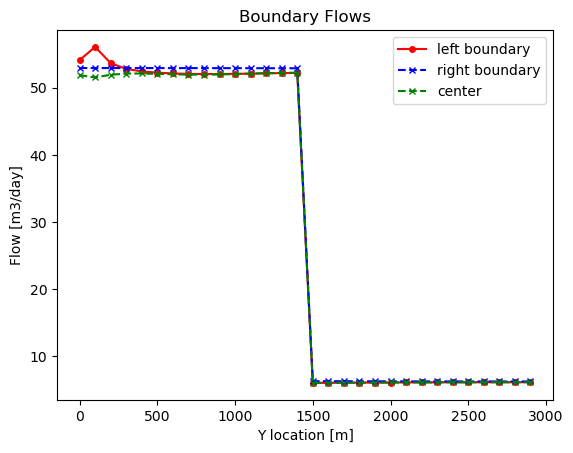

(30, 30)
52.081608
51.919815
[53.64761  52.081608 51.919815 51.97527  52.066616 52.175365 52.301838
 52.437866 52.56993  52.684135 52.77129  52.832726 52.874176 52.901653
 52.920055 52.92756  52.931534 52.933193 52.933353 52.932594 52.93131
 52.929775 52.92817  52.926636 52.925255 52.9241   52.9232   52.922585
 52.922276  0.      ]


In [90]:
budgobj = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
kstpkper_list = budgobj.get_kstpkper()          #returns a list of stress periods & timesteps
frf = budgobj.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff = budgobj.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells     
         #string options are in the list file under output control (make sure to include spaces!)

flux_vals=np.squeeze(frf)
leftflux = flux_vals[:,0]
rightflux = flux_vals[:,-2]
#centerflux = flux_vals[:,12]
centerflux = flux_vals[:,2]


bdryflux_fig = plt.figure() 
x=np.arange(0,ncol*dx,dx) 
plt.plot(x,leftflux,marker='o', color='red', markersize=4, linestyle='-',label="left boundary")
plt.plot(x,rightflux,marker='x', color='blue', markersize=4, linestyle='--',label="right boundary")
plt.plot(x,centerflux,marker='x', color='green', markersize=4, linestyle='--',label="center")
plt.xlabel('Y location [m]')
plt.ylabel('Flow [m3/day]')
plt.title("Boundary Flows")
plt.legend()
plt.show()

print(flux_vals.shape)
print(flux_vals[2,1])
print(flux_vals[2,2])
print(flux_vals[2,:])



### Calculate the total flux

In [81]:
head

array([[[20.       , 19.790804 , 19.58709  , 19.382334 , 19.175148 ,
         18.965218 , 18.752422 , 18.536663 , 18.31785  , 18.095905 ,
         17.870768 , 17.642387 , 17.410713 , 17.175686 , 16.937225 ,
         16.627722 , 16.244413 , 15.85177  , 15.44911  , 15.035643 ,
         14.610463 , 14.1725235, 13.720604 , 13.253275 , 12.768842 ,
         12.265271 , 11.74009  , 11.190243 , 10.611874 , 10.       ],
        [20.       , 19.783169 , 19.585999 , 19.382572 , 19.175627 ,
         18.965729 , 18.752935 , 18.537169 , 18.318329 , 18.096336 ,
         17.871132 , 17.64268  , 17.41094  , 17.175858 , 16.937353 ,
         16.627813 , 16.244473 , 15.851806 , 15.449128 , 15.035649 ,
         14.610462 , 14.172517 , 13.720595 , 13.253265 , 12.768832 ,
         12.265262 , 11.740083 , 11.190237 , 10.61187  , 10.       ],
        [20.       , 19.792582 , 19.589117 , 19.38416  , 19.176788 ,
         18.96678  , 18.753973 , 18.538198 , 18.319311 , 18.097214 ,
         17.871866 , 17.64326  ,

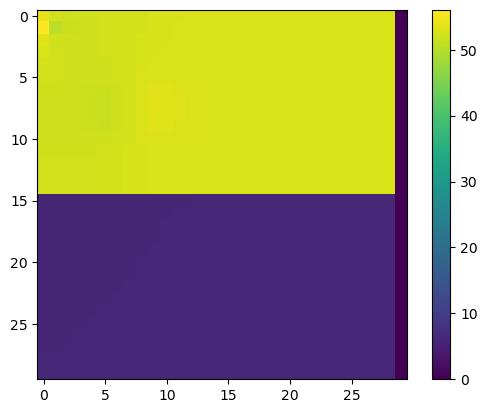

In [82]:
plt.imshow(flux_vals)
plt.colorbar()

In [83]:
flux_vals[:, 0]

array([54.10492  , 56.068817 , 53.64761  , 52.792263 , 52.42434  ,
       52.23207  , 52.119183 , 52.055218 , 52.029068 , 52.033237 ,
       52.05889  , 52.095818 , 52.134945 , 52.169724 , 52.196167 ,
        6.0316772,  6.0465994,  6.0601716,  6.0724044,  6.083342 ,
        6.093044 ,  6.101571 ,  6.1089835,  6.115337 ,  6.120683 ,
        6.1250663,  6.128526 ,  6.131092 ,  6.13279  ,  6.133635 ],
      dtype=float32)

In [84]:
#Calculate the total flux across the model
flux_tot  = np.sum(flux_vals[:, 0]) #total flux through one column of the model [m3/day]

# Calculate the equivalent K (q=k*A* dh/dl)
area = nrow *dy * (ztop-zbot)
dh_dl= (np.mean((H_init[0,:,0]-H_init[0,:,-1])))/Lx
#dh_dl = 10/2500
k_eff = flux_tot/area/dh_dl

# Calculate the arithmetic mean K
k_arr = np.mean(K_vals)

# Calcualte the harmonic mean K
k_harm = hmean(K_vals.flatten()) 

print("LowK", np.min(np.array([K_incl1,K_incl2,K_incl3,K_incl4,])), "ArrMean", np.round(k_arr,2), "Hmean", np.round(k_harm,2), "Keff", np.round(k_eff,2), "Q", np.round(flux_tot,2) )


LowK 1.0 ArrMean 5.98 Hmean 2.15 Keff 0.44 Q 881.65


In [85]:
ztop-zbot

200.0

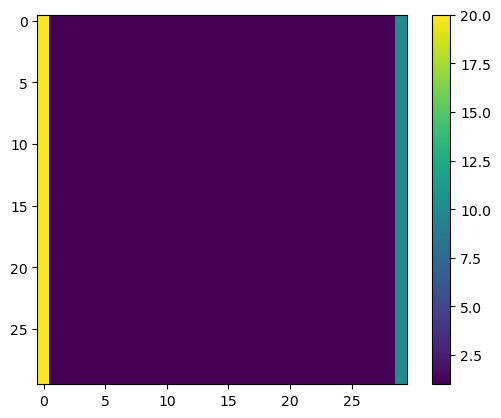

In [86]:
plt.imshow(H_init[0,:,:])
plt.colorbar()

#### 10.2 Evaluate the head gradients

Head Gradient 0.0033333334 m/m


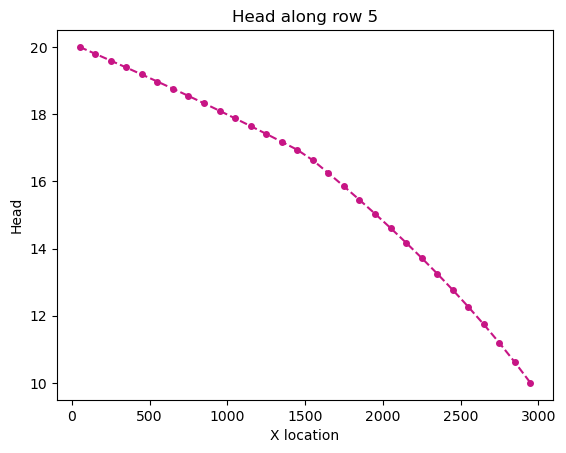

In [87]:
head_fig = plt.figure() 
#x=np.arange(100,2600,100) 
x=np.arange(dx/2,Lx,dx)
y=head[0,4,:]
plt.plot(x,y,marker='o', color='mediumvioletred', markersize=4, linestyle='--')
plt.xlabel('X location')
plt.ylabel('Head')
plt.title("Head along row 5")
#plt.axvline(x=1200)

#Save figure
# plt.savefig('Head_Transect.png') #save figure as a png

hgrad=(head[0,4,0]-head[0,4,-1])/Lx
print("Head Gradient", hgrad, "m/m") 

#### 10.3 3D plot of heads

Text(0.5, 0.92, 'Steady-State Model Head Profile')

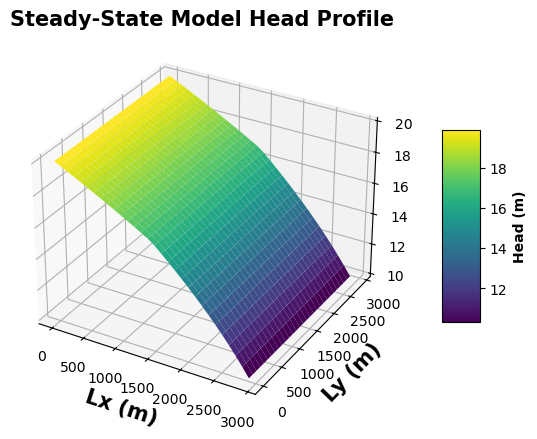

In [88]:
#create 3d figure
fig_3d = plt.figure(figsize=(12,5))
#ax = fig_3d.gca(projection='3d')
ax = fig_3d.add_subplot(111,projection='3d')

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(head[0])

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('Steady-State Model Head Profile', fontsize=15, fontweight='bold')
# plt.savefig('BoxModel_Surface1.png') 
#plt.show(surf)

### 10.4 Contour Head plot

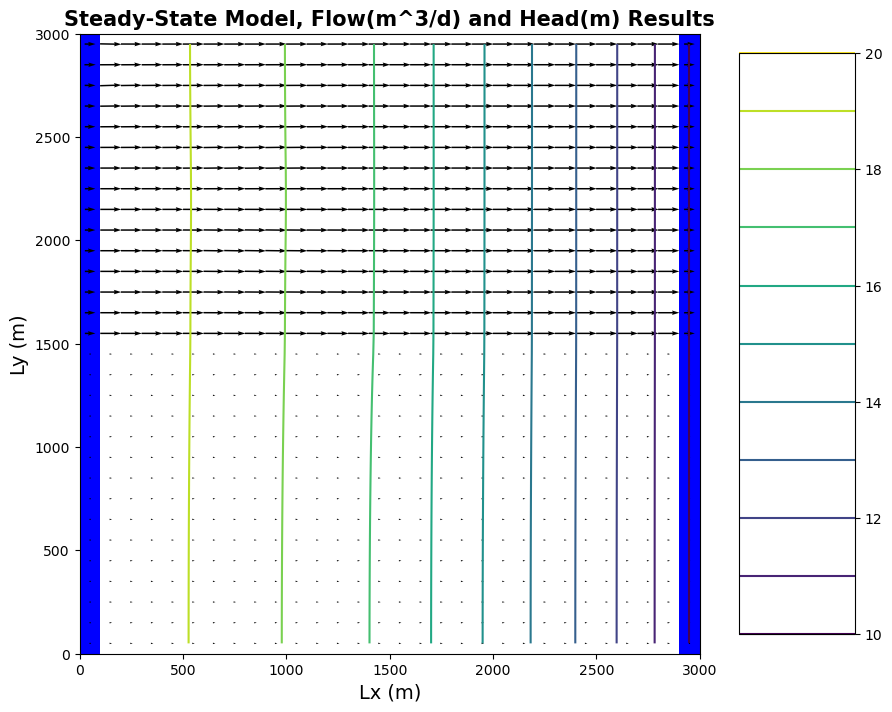

In [89]:
#Calculate the volumetric dischard (m3/day)
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
    (frf[0], fff[0], None), m) 

#plot first contour plot
fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head[0].min(),head[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
quiver = modelmap.plot_vector(qx, qy)
#flows = modelmap.plot_discharge(frf[0], fff[0], head=head) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Steady-State Model, Flow(m^3/d) and Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
# plt.savefig('BoxModel_vectors.png')   
#plt.show(modelmap)